In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


from sklearn.cluster import KMeans

In [2]:
def remove_cars(image_paths):
    images = np.array([cv2.imread(image_path) for image_path in image_paths])

    mean_image = np.median(images, axis=0).astype(np.uint8)
    mean_image_rgb = cv2.cvtColor(mean_image, cv2.COLOR_BGR2RGB)

    # Convert the mean image to the Lab color space
    mean_image_lab = cv2.cvtColor(mean_image_rgb, cv2.COLOR_RGB2Lab)

    # Reshape the image to a 2D array of pixels
    pixel_array = mean_image_lab.reshape((-1, 3))

    # Apply k-means clustering to group the pixels into clusters
    kmeans = KMeans(n_init='auto').fit(pixel_array)

    # Identify the cluster that corresponds to the cars
    car_cluster = np.argmin(kmeans.cluster_centers_.sum(axis=1))

    # Create a mask that selects only the pixels in the car cluster
    car_mask = (kmeans.labels_ == car_cluster).reshape(mean_image.shape[:2])

    # Apply the mask to the mean image to remove the cars
    result_image = mean_image_rgb.copy()
    result_image[car_mask] = [255, 255, 255]  # Replace car pixels with white

    plt.imsave("result.jpg", result_image)
    return None

In [76]:
def remove_car_from_one_image(color_img):
    img = np.array(color_img)
    kernel_size = (3, 3)  # Adjust the kernel size as needed
    img = cv2.GaussianBlur(img, kernel_size, 0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img = np.array(color_img)
    thresh = cv2.Laplacian(img, cv2.CV_64F)


    plt.imshow(thresh)

In [57]:
def remove_cars_with_segmenting(image_paths):
    images = [cv2.imread(image_path) for image_path in image_paths]

    images_gray = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

    gray = images[0]
    _,thresh = cv2.threshold(gray, np.mean(gray), 255, cv2.THRESH_BINARY_INV)

    plt.axis('off')
    plt.imshow(thresh)
    return thresh

In [5]:
image_paths = ["./images/image1.JPG",
               "./images/image2.JPG", "./images/image3.JPG"]
result_images = remove_cars(image_paths)

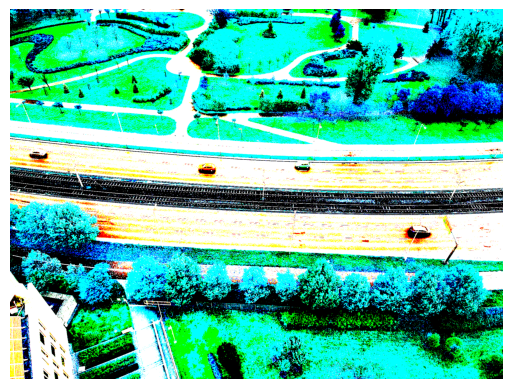

In [58]:
mat = remove_cars_with_segmenting(image_paths)

In [46]:
img = cv2.imread(image_paths[0])

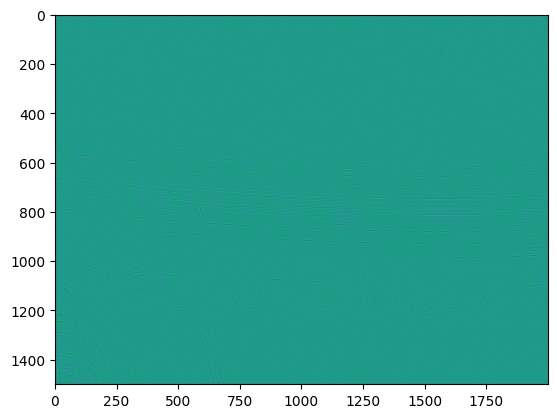

In [77]:
remove_car_from_one_image(img)

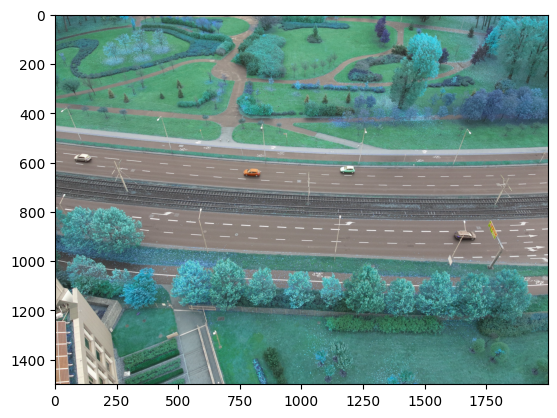

In [91]:
img = cv2.imread(image_paths[0])
plt.imshow(img)

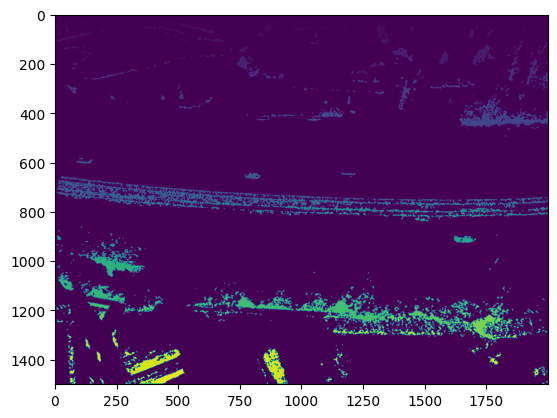

In [121]:

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Noise removal
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# Sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=1)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

plt.imshow(markers)